In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 0) #To display entire text content of a column
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, f1_score
import timeit
import os
import pickle
import joblib as joblib
import re
from functools import reduce
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#Read csv
X_train = pd.read_csv('s3://apandey-bstn-bucket/X_train_clean_transformed.csv')

#y_train column vector
y_train_col_vector = pd.read_csv('s3://apandey-bstn-bucket/y_train.csv', header = None)
#Convert y_train to a series
y_train = y_train_col_vector[0]

X_test = pd.read_csv('s3://apandey-bstn-bucket/X_test_clean_transformed.csv')

#y test column vector
y_test_col_vector = pd.read_csv('s3://apandey-bstn-bucket/y_test.csv', header = None)
#Convert y_test to a series
y_test = y_test_col_vector[0]

In [3]:
#Verify
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)
display(X_train.head(1))
display(y_train.head(1))

(120398, 654)

(120398,)

(30100, 654)

(30100,)

,abl,absolut,accept,access,account,action,activ,actual,ad,add,...,would recommend,write,wrong,x,ye,year,year ago,year old,yet,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    1
Name: 0, dtype: int64

In [4]:
#Log reg pipeline for optimal recall
estimators = [('model', LogisticRegression(max_iter = 300))]

pipe = Pipeline(estimators)

param_grid = [
    {#l1
        'model__penalty':['l1'],
        'model__solver' :['liblinear'],
        'model__C': np.logspace(-3,3,7)
        
    },
    {#l2
        'model__penalty':['l2'],
        'model__solver' :['liblinear','lbfgs','saga'],
        'model__C': np.logspace(-3,3,7)
        
    },
    {#elasticnet
        'model__penalty':['elasticnet'],
        'model__l1_ratio':np.arange(0.2,0.8,0.1),
        'model__solver' :['saga'],
        'model__C': np.logspace(-3,3,7)
    },
    {#No penalty
        'model__penalty':['none'],
        'model__solver' :['lbfgs']}
]

log_reg_grid_recall = GridSearchCV(
estimator = pipe,
param_grid = param_grid,
cv = 5,
verbose = 5,
n_jobs = -1,
scoring = 'recall')

log_reg_grid_recall.fit(X_train, y_train)

Fitting 5 folds for each of 78 candidates, totalling 390 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 69.2min
[Parallel(n_jobs=-1)]: Done 390 out of 390 | elapsed: 145.5min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=300,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                                               

In [5]:
log_reg_grid_recall.best_params_

{'model__C': 100.0,
 'model__l1_ratio': 0.8000000000000003,
 'model__penalty': 'elasticnet',
 'model__solver': 'saga'}

In [10]:
#Accuracies
print(f"The accuracy of optimized Log reg on train set is: {round(log_reg_grid_recall.score(X_train, y_train),2)}")
print(f"The accuracy of optimized Log reg on test set is: {round(log_reg_grid_recall.score(X_test, y_test),2)}")

The accuracy of optimized Log reg on train set is: 0.71
The accuracy of optimized Log reg on test set is: 0.71


In [12]:
#Predict and verify metrics
y_pred_log_reg_grid_recall = log_reg_grid_recall.predict(X_test)
print(classification_report(y_test, y_pred_log_reg_grid_recall)) 

              precision    recall  f1-score   support

           0       0.75      0.86      0.80     15038
           1       0.83      0.71      0.77     15062

    accuracy                           0.78     30100
   macro avg       0.79      0.78      0.78     30100
weighted avg       0.79      0.78      0.78     30100



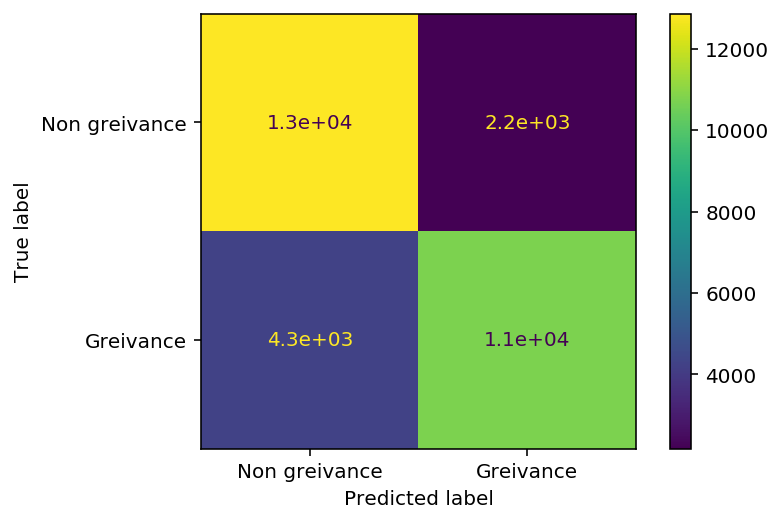

In [13]:
#Confusion matrix
y_pred_log_reg_grid_recall = log_reg_grid_recall.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_log_reg_grid_recall)
cf_matrix

# Plot
ConfusionMatrixDisplay(cf_matrix, display_labels=['Non greivance','Greivance']).plot()
plt.show()

In [19]:
#recall
precision_score(y_test,y_pred_log_reg_grid_recall )

0.830488750969744

In [14]:
#Save grid
joblib.dump(log_reg_grid_recall, 'optimized_log_reg_grid_recall.pkl')

['optimized_log_reg_grid_recall.pkl']

In [4]:
#Verify saved model
downlaoded_model_verification = joblib.load('optimized_log_reg_grid_recall.pkl')

downlaoded_model_verification.score(X_test, y_test)

0.7144469525959368

In [5]:
downlaoded_model_verification.best_estimator_

Pipeline(memory=None,
         steps=[('model',
                 LogisticRegression(C=100.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.8000000000000003, max_iter=300,
                                    multi_class='auto', n_jobs=None,
                                    penalty='elasticnet', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [6]:
log_reg = LogisticRegression(C=100.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.8000000000000003, max_iter=300,
                                    multi_class='auto', n_jobs=None,
                                    penalty='elasticnet', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False)
log_reg.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.8000000000000003,
                   max_iter=300, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [7]:
y_pred_best_fit = log_reg.predict(X_test)

In [8]:
print(classification_report(y_test, y_pred_best_fit)) 

              precision    recall  f1-score   support

           0       0.75      0.86      0.80     15038
           1       0.83      0.71      0.77     15062

    accuracy                           0.78     30100
   macro avg       0.79      0.78      0.78     30100
weighted avg       0.79      0.78      0.78     30100



In [10]:
#Save the best fit
log_reg_best_fit = joblib.dump(log_reg, 'log_reg_best_fit.pkl')

# Random forest

In [4]:
#Random forest grid search
estimators = [('model', RandomForestClassifier())]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model__max_features':['auto','log2', 0.1, 0.5],
        'model__n_estimators': np.arange(100,401,100),
        'model__min_samples_leaf': [5]
    }]

rand_forest_grid_recall = GridSearchCV(
estimator = pipe,
param_grid = param_grid,
cv = 3,
verbose = 5,
n_jobs = -1,
scoring = 'recall')
rand_forest_grid_recall.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed: 10.0min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  37 out of  48 | elapsed: 30.2min remaining:  9.0min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 86.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                            

In [5]:
rand_forest_grid_recall.best_params_

{'model__max_features': 'auto',
 'model__min_samples_leaf': 5,
 'model__n_estimators': 400}

In [6]:
#Accuracies
print(f"The accuracy of optimized Random Forest on train set is: {round(rand_forest_grid_recall.score(X_train, y_train),2)}")
print(f"The accuracy of optimized Random Forest set is: {round(rand_forest_grid_recall.score(X_test, y_test),2)}")

The accuracy of optimized Random Forest on train set is: 0.79
The accuracy of optimized Random Forest set is: 0.76


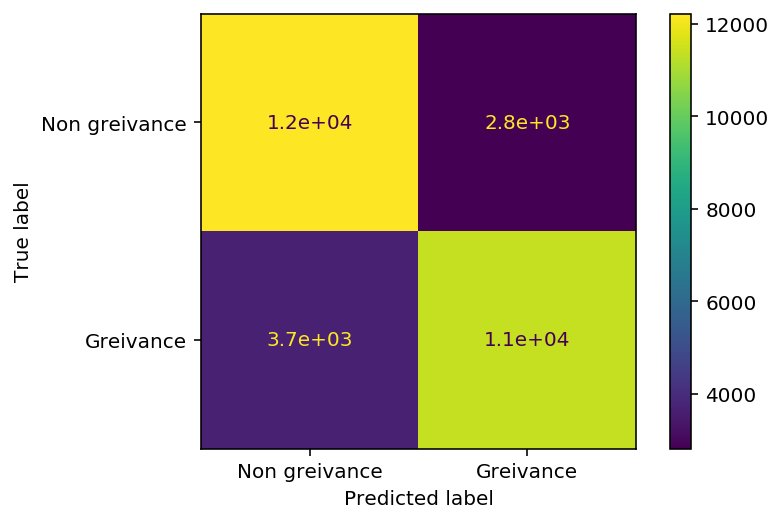

In [7]:
#Confusion matrix
y_pred_rand_forest_grid_recall= rand_forest_grid_recall.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_rand_forest_grid_recall)
cf_matrix

# Plot
ConfusionMatrixDisplay(cf_matrix, display_labels=['Non greivance','Greivance']).plot()
plt.show()

In [11]:
#Predict and verify metrics
print(classification_report(y_test, y_pred_rand_forest_grid_recall)) 

              precision    recall  f1-score   support

           0       0.77      0.81      0.79     15038
           1       0.80      0.76      0.78     15062

    accuracy                           0.78     30100
   macro avg       0.79      0.78      0.78     30100
weighted avg       0.79      0.78      0.78     30100



In [12]:
#Save grid
joblib.dump(rand_forest_grid_recall, 'optimized_rand_forest_grid_recall.pkl')

['optimized_rand_forest_grid_recall.pkl']

In [12]:
optimized_rand_forest_grid_recall.best_estimator_

Pipeline(memory=None,
         steps=[('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=400, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [13]:
rand_forest_best_fit = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=400, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)
rand_forest_best_fit.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [5]:
rand_forest_best_fit.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
joblib.dump(rand_forest_best_fit, 'rand_forest_best_fit.pkl')

['rand_forest_best_fit.pkl']

In [16]:
#Check score
rand_forest_best_fit.score(X_train, y_train)

0.8242578780378411

In [11]:
#Load
optimized_rand_forest_grid_recall = joblib.load('optimized_rand_forest_grid_recall.pkl')